In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import scipy.integrate

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.manual_seed(7)
np.random.seed(7)

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [4]:
def system(t,z):
  q1 = z[0:1]
  q2 = z[1:2]
  p1 = z[2:3]
  p2 = z[3:4]

  dqdt = np.concatenate([5*p1-p2, -p1+5*p2])
  dpdt = np.concatenate([-q1*q1*q1-q2, -q2*q2*q2-q1])
  return np.concatenate([dqdt,dpdt])

In [5]:
#Make the dataset
K = 3 #how many trajectory segments come out from one initial condition
L = 300 #how many trajectories
N = int(K*L) #how many trajcectory segments
s = 2
M = 6 #number of sampled points (after final time)
T = .3 #final sampling time
time = np.linspace(0,T,M)
dt = time[1] - time[0]
print(dt)
q = 2*np.random.rand(N,s) - 1  #we suppose them organized as z = [q1,...,qs,p1,...,ps]
p = 2*np.random.rand(N,s) - 1
z = np.concatenate([q,p],axis=1)

0.06


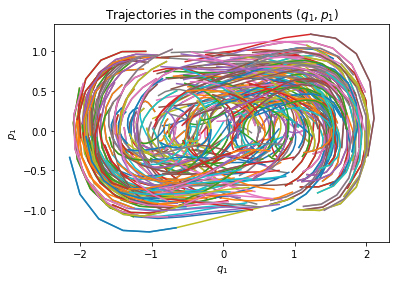

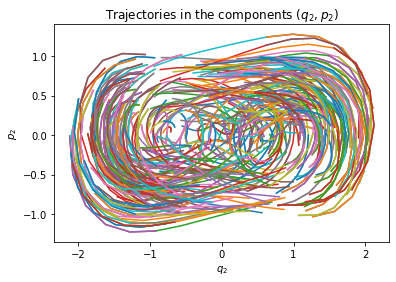

In [6]:
timeEval = np.linspace(0,T,M)

traj = np.zeros([N,2*s,M])
for i in np.arange(0,N,K):
  #This strategy allows to cover the space in the phase space covered by trajectories up to time T=1
  for j in range(K):
    if j==0:
      traj[i,:,:] = scipy.integrate.solve_ivp(system,[0, T],z[i],method='RK45',t_eval=timeEval,rtol=1e-11,atol=1e-13).y
    else:
      traj[i+j,:,:] = scipy.integrate.solve_ivp(system,[0, T],traj[i,:,-1],method='RK45',t_eval=timeEval,rtol=1e-11,atol=1e-13).y

for i in range(N):
  plt.plot(traj[i,0],traj[i,2])
  plt.xlabel(r"$q_1$")
  plt.ylabel(r"$p_1$")
plt.title(r"Trajectories in the components $(q_1,p_1)$")
plt.show()
for i in range(N):
  plt.plot(traj[i,1],traj[i,3])
  plt.xlabel(r"$q_2$")
  plt.ylabel(r"$p_2$")
plt.title(r"Trajectories in the components $(q_2,p_2)$")
plt.show()

In [7]:
X = traj[:,:,0]
Y = traj[:,:,1:M]
Ntrain = N

In [8]:
from torch.utils.data import Dataset, DataLoader
class dataset(Dataset):
  def __init__(self,x,y):
    self.x = torch.from_numpy(x.astype(np.float32)).to(device)
    self.y = torch.from_numpy(y.astype(np.float32)).to(device)
    self.length = self.x.shape[0]
 
  def __getitem__(self,idx):
    return self.x[idx],self.y[idx]
  def __len__(self):
    return self.length

trainset = dataset(X[:Ntrain,:],Y[:Ntrain])

In [9]:
batch_size = 50
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

In [10]:
K = 100

class SinActivation(nn.Module):
    def __init__(self, ):
        super(SinActivation, self).__init__()
    def forward(self,x):
        return torch.sin(x)

class Hamiltonian(nn.Module):
    def __init__(self, ):
        super(Hamiltonian, self).__init__()
        
        self.IV = nn.Linear(s,K) 
        self.nl = nn.Tanh()
        #self.nl = SinActivation()
        
        lin = []
        lin.append(nn.Linear(K,K//2))
        lin.append(self.nl)
        lin.append(nn.Linear(K//2, K//2))
        lin.append(self.nl)
        self.seqTr = nn.Sequential(*lin)

        self.OV = nn.Linear(K//2,1,bias=False)

        self.A = torch.nn.Parameter(torch.randn(s,s))
        
    def Kinetic(self, X):
        k = (0.5 * torch.linalg.norm(X[:,s:]@torch.transpose(self.A,0,1),axis=1,ord=2)**2).unsqueeze(1)
        return k
    
    def Potential(self, X):
        z = self.nl(self.IV(X[:,0:s]))
        z = self.seqTr(z)
        v = self.OV(z)
        return v

    def forward(self, X):
        o = self.Potential(X) + self.Kinetic(X)
        return o

### Training with regularization

In [11]:
Ham = Hamiltonian()
Ham.to(device)

Hamiltonian(
  (IV): Linear(in_features=2, out_features=100, bias=True)
  (nl): Tanh()
  (seqTr): Sequential(
    (0): Linear(in_features=100, out_features=50, bias=True)
    (1): Tanh()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Tanh()
  )
  (OV): Linear(in_features=50, out_features=1, bias=False)
)

In [12]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(Ham.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

In [13]:
I = torch.eye(s)
Z = torch.zeros([s,s])
J1 = torch.cat([Z,I],axis=1)
J2 = torch.cat([-I,Z],axis=1)
J = torch.cat([J1,J2],axis = 0).to(device) #Symplectic matrix
print(J)

tensor([[ 0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  1.],
        [-1., -0.,  0.,  0.],
        [-0., -1.,  0.,  0.]])


In [14]:
def ExpEuler(x0):
  N = len(x0) #number of points propagated in time
  x = x0.clone().to(device)
  x.requires_grad_()
  sol = torch.zeros([len(x0), 2*s, M-1]).to(device)
  for i in range(M-1):
    H = torch.sum(Ham(x))
    dH = torch.autograd.grad(H, x, create_graph=True)[0]
    XH= -dH@J #compute the Hamiltonian vector field

    x = x + dt * XH 
    sol[:,:,i] = x.to(device)
  
  return(sol) #stored trajectories

def StormerVerlet(x0):
  N = len(x0) #number of points propagated in time
  x = x0.clone().to(device)
  x.requires_grad_()
  sol = torch.zeros([len(x0), 2*s, M-1 ])
  for i in range(M-1):

    #x@Mat1 = [0,x[:,1]], x@Mat0 = [x[:,0],0]
    #q@N0 = [q,0] e p@N1 = [0,p]
    id = torch.eye(s)
    zz = torch.zeros((s,s))
    
    N0 = torch.cat((id,zz),axis=1).to(device)
    N1 = torch.cat((zz,id),axis=1).to(device)

    H = torch.sum(Ham(x))
    dH = torch.autograd.grad(H, x, create_graph=True)[0]
    XH= -dH@J
    x = x + dt/2 * (XH[:,s:2*s])@N1 #update p to phalf


    H1 = torch.sum(Ham(x))
    dH1 = torch.autograd.grad(H1, x, create_graph=True)[0]
    XH1= -dH1@J
    x = x + dt * (XH1[:,0:s])@N0 #update for q 


    H2 = torch.sum(Ham(x))
    dH2 = torch.autograd.grad(H2, x, create_graph=True)[0]
    XH2= -dH2@J

    x = x + dt/2 * (XH2[:,s:2*s])@N1 #update phalf to pnew
    sol[:,:,i] = x
  return(sol) #stored trajectories

In [15]:
integrator = StormerVerlet

In [16]:
checkpoint = 20

for epoch in range(100):

    running_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        inputs.requires_grad_()
        optimizer.zero_grad()

        predicted = integrator(inputs)
        loss = criterion(predicted, labels)

        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if i % checkpoint == 0:  
            print('[%d, %5d] loss: %.10f' %
                  (epoch + 1, i + 1, running_loss / checkpoint))
            running_loss = 0.0

    scheduler.step()

print('Finished Training')

[1,     1] loss: 0.0086521678
[2,     1] loss: 0.0013894283
[3,     1] loss: 0.0007890733
[4,     1] loss: 0.0002617570
[5,     1] loss: 0.0001226694
[6,     1] loss: 0.0000571946
[7,     1] loss: 0.0000259543
[8,     1] loss: 0.0000210179
[9,     1] loss: 0.0000125030
[10,     1] loss: 0.0000336881
[11,     1] loss: 0.0000159358
[12,     1] loss: 0.0000102888
[13,     1] loss: 0.0000045538
[14,     1] loss: 0.0000030253
[15,     1] loss: 0.0000021933
[16,     1] loss: 0.0000051054
[17,     1] loss: 0.0000062940
[18,     1] loss: 0.0000132109
[19,     1] loss: 0.0000230166
[20,     1] loss: 0.0000253564
[21,     1] loss: 0.0000106775
[22,     1] loss: 0.0000188719
[23,     1] loss: 0.0000103865
[24,     1] loss: 0.0000193943
[25,     1] loss: 0.0000046766
[26,     1] loss: 0.0000044029
[27,     1] loss: 0.0000100462
[28,     1] loss: 0.0000254991
[29,     1] loss: 0.0000327453
[30,     1] loss: 0.0000204945
[31,     1] loss: 0.0000301187
[32,     1] loss: 0.0000061735
[33,     1] loss:

In [17]:
print(f"A: ",torch.transpose(Ham.A,0,1)@Ham.A)

A:  tensor([[ 4.9684, -1.0039],
        [-1.0039,  4.9631]], grad_fn=<MmBackward0>)


In [18]:
#if i = 1 it returns q1,p1, if i=2 it returns q2,p2 eventually for all the times available
def get_i(z,i):
  if len(z.shape)==2:
    qi = z[:,0+i-1:1+i-1].reshape(-1,1,1)
    pi = z[:,2+i-1:3+i-1].reshape(-1,1,1)
    return np.concatenate([qi,pi],axis=1)
  if len(z.shape)==3:
    qi = z[:,0+i-1:1+i-1,:]
    pi = z[:,2+i-1:3+i-1,:]
    return np.concatenate([qi,pi],axis=1)

In [19]:
TT = 1
timeEval = np.linspace(0,TT,20)

In [20]:
def predictedModel(t,x):
  z = torch.from_numpy(x.astype(np.float32)).to(device).requires_grad_()
  uu = Ham(z.unsqueeze(0))
  dHy = torch.autograd.grad(uu,z)[0].t()
  XHH = (J@dHy).t().cpu().detach().numpy()
  return XHH

In [21]:
Ntest = 100
q = 2*np.random.rand(Ntest,s) - 1
p = 2*np.random.rand(Ntest,s) - 1
ics = np.concatenate([q,p],axis=1) #initial conditions

In [22]:
Ztrue = np.zeros([len(ics),2*s,len(timeEval)])
Zpred = np.zeros([len(ics),2*s,len(timeEval)])

for i in range(Ntest):
  Ztrue[i,:,:] = scipy.integrate.solve_ivp(system,[0, TT],ics[i],method='RK45',t_eval=timeEval,rtol=1e-5,atol=1e-9).y
for i in range(Ntest):
  Zpred[i,:,:] = scipy.integrate.solve_ivp(predictedModel,[0, TT],ics[i],method='RK45',t_eval=timeEval,rtol=1e-5,atol=1e-9).y

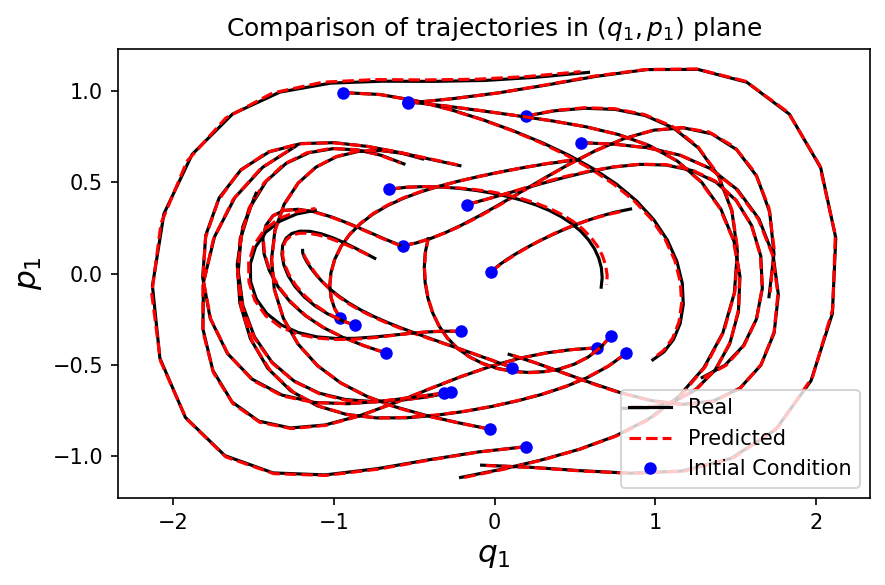

In [23]:
fig, ax = plt.subplots(dpi=150)

ax.plot(Ztrue[0,0],Ztrue[0,2],'k-',markersize=3,label="Real")
ax.plot(Zpred[0,0],Zpred[0,2],'r--',markersize=0.5,label="Predicted")

for i in np.arange(1,Ntest,5):
  #ax.plot(Ztrue[i,0,0],Ztrue[i,2,0],'r*',markersize=3)
  ax.plot(Ztrue[i,0],Ztrue[i,2],'k-',markersize=3)
  ax.plot(Zpred[i,0],Zpred[i,2],'r--',markersize=0.5)
  ax.plot(Zpred[i,0,0],Zpred[i,2,0],'bo',markersize=5)
  
ax.plot(Zpred[0,0,0],Zpred[0,2,0],'bo',markersize=5,label="Initial Condition")

ax.set_xlabel(r"$q_1$",fontsize=15)
ax.set_ylabel(r"$p_1$",fontsize=15)
plt.title(r"Comparison of trajectories in $(q_1,p_1)$ plane")
plt.legend()
plt.tight_layout()
plt.savefig("q1p1.png",dpi=600)
plt.show()

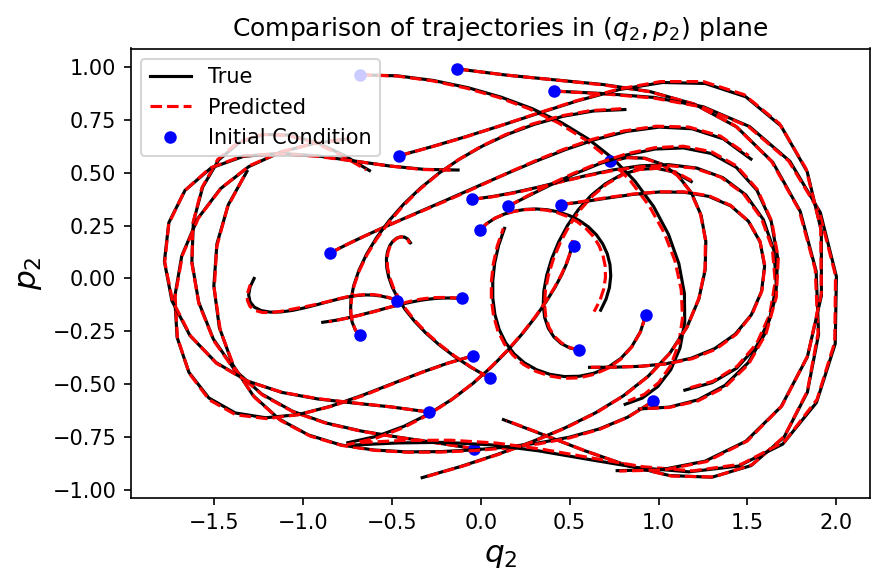

In [24]:
fig, ax = plt.subplots(dpi=150)

ax.plot(Ztrue[0,1],Ztrue[0,3],'k-',markersize=3,label="True")
ax.plot(Zpred[0,1],Zpred[0,3],'r--',markersize=0.5,label="Predicted")

for i in np.arange(1,Ntest,5):
  ax.plot(Ztrue[i,1],Ztrue[i,3],'k-',markersize=3)
  ax.plot(Zpred[i,1],Zpred[i,3],'r--',markersize=0.5)
  ax.plot(Zpred[i,1,0],Zpred[i,3,0],'bo',markersize=5)
ax.plot(Zpred[0,1,0],Zpred[0,3,0],'bo',markersize=5,label="Initial Condition")
 
ax.set_xlabel(r"$q_2$",fontsize=15)
ax.set_ylabel(r"$p_2$",fontsize=15)
plt.title(r"Comparison of trajectories in $(q_2,p_2)$ plane")
plt.legend()
plt.tight_layout()
plt.savefig("q2p2.png",dpi=600)
plt.show()

In [25]:
print("MSE on test trajectories with RK45 as integrator: ",np.mean((Zpred-Ztrue)**2))

MSE on test trajectories with RK45 as integrator:  6.596668775420664e-05
